In [8]:
# @title Light Curve Classification for Exoplanet Detection
print("LIGHT CURVE CLASSIFICATION...")

!pip install lightkurve astropy torch torchvision scikit-learn matplotlib pandas numpy
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import roc_curve, auc, classification_report
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

print("packages loaded!")

LIGHT CURVE CLASSIFICATION...
packages loaded!


GENERATING SYNTHETIC LIGHT CURVE DATA...
Generated 2000 light curves
Class distribution: 1000 planets, 1000 non-planets


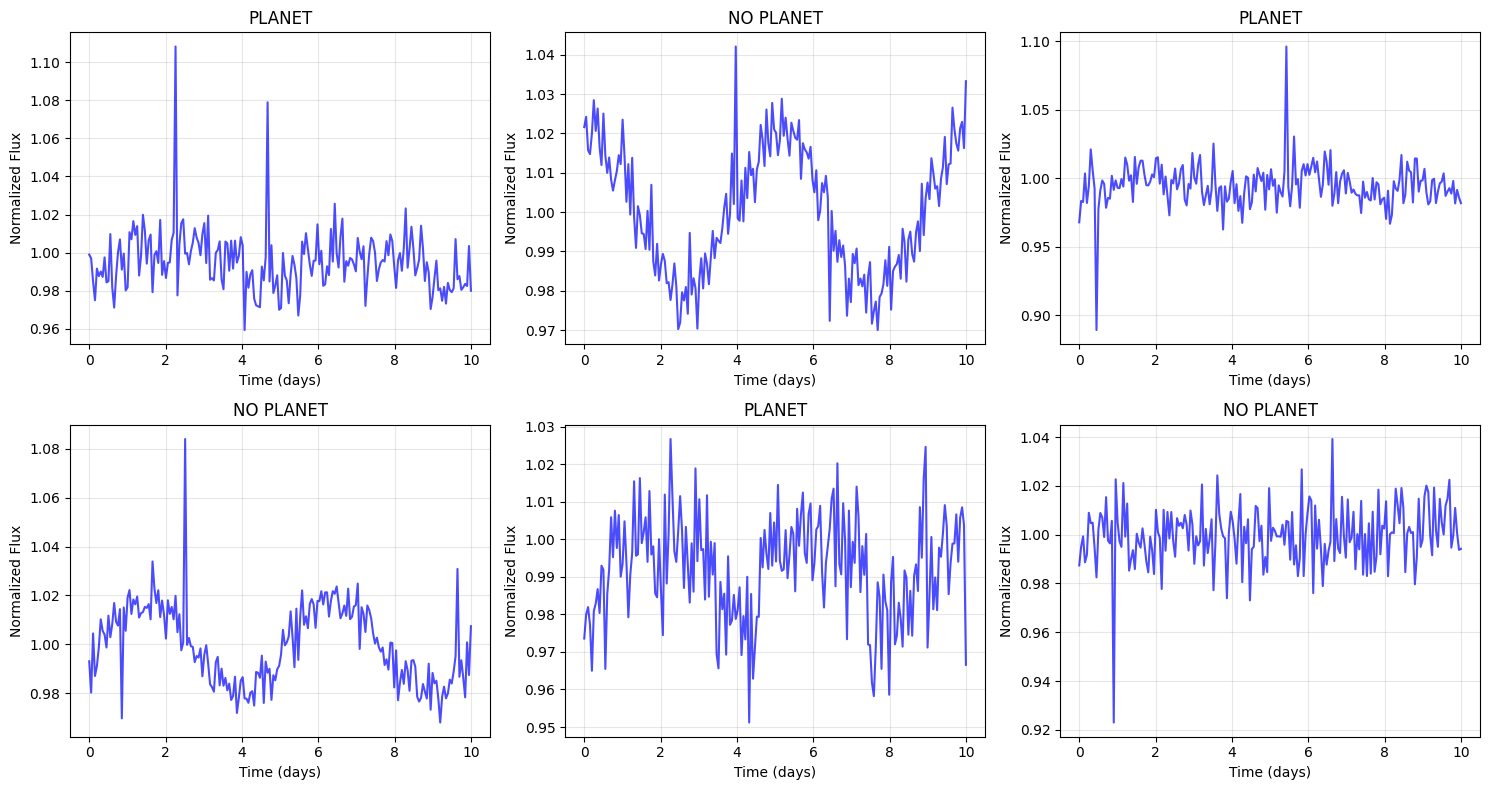

In [9]:
# @title Generate Synthetic Light Curve Data
print("GENERATING SYNTHETIC LIGHT CURVE DATA...")

def generate_light_curves(num_samples=2000, sequence_length=200):
    """
    Generate synthetic light curves with and without planetary transits
    """
    light_curves = []
    labels = []

    for i in range(num_samples):
        time = np.linspace(0, 10, sequence_length)

        if i % 2 == 0:
            # Creating a star with periodic dimming
            baseline = 1.0 + 0.01 * np.random.normal(size=sequence_length)  # Small noise

            # Adding planetary transit
            period = 3 + 2 * np.random.random()  # Random period between 3-5 days
            depth = 0.01 + 0.02 * np.random.random()  # Transit depth 1-3%
            duration = 0.1 + 0.1 * np.random.random()  # Transit duration

            # Creating transit signal
            transit_signal = np.ones_like(time)
            phase = (time % period) / period
            transit_mask = (phase < duration) | (phase > (1 - duration))
            transit_signal[transit_mask] = 1 - depth

            flux = baseline * transit_signal
            label = 1  # Planet present

        else:  # NO PLANET
            # Just noise and maybe some stellar variability
            if np.random.random() > 0.5:
                # Smooth stellar variation
                variation = 0.02 * np.sin(2 * np.pi * time / 5 + np.random.random() * 2 * np.pi)
                noise = 0.005 * np.random.normal(size=sequence_length)
                flux = 1.0 + variation + noise
            else:
                # Pure noise
                flux = 1.0 + 0.01 * np.random.normal(size=sequence_length)
            label = 0  # No planet

        # Adding some random outliers and final noise
        outlier_mask = np.random.random(sequence_length) < 0.02
        flux[outlier_mask] += 0.05 * np.random.normal(size=np.sum(outlier_mask))

        flux += 0.003 * np.random.normal(size=sequence_length)  # Final noise

        light_curves.append(flux)
        labels.append(label)

    return np.array(light_curves), np.array(labels)

# Generating dataset
light_curves, labels = generate_light_curves(num_samples=2000)
print(f"Generated {len(light_curves)} light curves")
print(f"Class distribution: {np.sum(labels)} planets, {len(labels) - np.sum(labels)} non-planets")

# Plotting examples
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
time = np.linspace(0, 10, 200)

for i in range(6):
    row, col = i // 3, i % 3
    axes[row, col].plot(time, light_curves[i], 'b-', alpha=0.7)
    axes[row, col].set_title(f"{'PLANET' if labels[i] == 1 else 'NO PLANET'}")
    axes[row, col].set_ylabel('Normalized Flux')
    axes[row, col].set_xlabel('Time (days)')
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [10]:
# @title Light Curve Dataset Class
print("CREATING LIGHT CURVE DATASET...")

class LightCurveDataset(Dataset):
    def __init__(self, light_curves, labels):
        self.light_curves = light_curves
        self.labels = labels

    def __len__(self):
        return len(self.light_curves)

    def __getitem__(self, idx):
        # Converting to tensor and adding channel dimension
        lc = torch.FloatTensor(self.light_curves[idx]).unsqueeze(0)  # Shape: (1, sequence_length)
        label = torch.LongTensor([self.labels[idx]])
        return lc, label

# Creating dataset
dataset = LightCurveDataset(light_curves, labels)

# Splitting into train/validation/test
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size]
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Dataset created: Train={train_size}, Val={val_size}, Test={test_size}")

CREATING LIGHT CURVE DATASET...
Dataset created: Train=1400, Val=300, Test=300


In [11]:
# @title 1D CNN Classifier for Light Curves
print("BUILDING 1D CNN CLASSIFIER...")

class LightCurveClassifier(nn.Module):
    def __init__(self, sequence_length=200, num_classes=2):
        super(LightCurveClassifier, self).__init__()

        self.features = nn.Sequential(
            # First conv block
            nn.Conv1d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2),

            # Second conv block
            nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2),

            # Third conv block
            nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2),

            # Fourth conv block
            nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool1d(8)  # Fixed size output
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 8, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Initialiing model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LightCurveClassifier().to(device)
print(f" 1D CNN Classifier ready on {device}")
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

BUILDING 1D CNN CLASSIFIER...
 1D CNN Classifier ready on cpu
Parameters: 397,250


In [12]:
# @title Train Light Curve Classifier
print("TRAINING LIGHT CURVE CLASSIFIER...")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

num_epochs = 50
train_losses = []
val_losses = []
val_accuracies = []

best_accuracy = 0.0

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device).squeeze()

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device).squeeze()
            output = model(data)
            val_loss += criterion(output, target).item()

            pred = output.argmax(dim=1)
            correct += (pred == target).sum().item()
            total += target.size(0)

    train_loss_avg = train_loss / len(train_loader)
    val_loss_avg = val_loss / len(val_loader)
    val_accuracy = 100. * correct / total

    train_losses.append(train_loss_avg)
    val_losses.append(val_loss_avg)
    val_accuracies.append(val_accuracy)

    scheduler.step(val_loss_avg)

    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"   Train Loss: {train_loss_avg:.4f} | Val Loss: {val_loss_avg:.4f}")
    print(f"   Val Accuracy: {val_accuracy:.2f}%")

    # Save best model
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_light_curve_classifier.pth')
        print("   NEW BEST MODEL SAVED!")

    # Early stopping
    if val_accuracy > 95.0:  # Excellent accuracy
        print("   Target accuracy reached!")
        break

print(f"Training completed! Best validation accuracy: {best_accuracy:.2f}%")
model.load_state_dict(torch.load('best_light_curve_classifier.pth'))

TRAINING LIGHT CURVE CLASSIFIER...
Epoch 1/50:
   Train Loss: 0.1464 | Val Loss: 1.1529
   Val Accuracy: 57.67%
   NEW BEST MODEL SAVED!
Epoch 2/50:
   Train Loss: 0.0434 | Val Loss: 1.0703
   Val Accuracy: 73.33%
   NEW BEST MODEL SAVED!
Epoch 3/50:
   Train Loss: 0.0334 | Val Loss: 0.3549
   Val Accuracy: 84.67%
   NEW BEST MODEL SAVED!
Epoch 4/50:
   Train Loss: 0.0211 | Val Loss: 0.7901
   Val Accuracy: 78.67%
Epoch 5/50:
   Train Loss: 0.0072 | Val Loss: 1.7738
   Val Accuracy: 67.00%
Epoch 6/50:
   Train Loss: 0.0181 | Val Loss: 3.1690
   Val Accuracy: 64.67%
Epoch 7/50:
   Train Loss: 0.0089 | Val Loss: 2.6787
   Val Accuracy: 62.00%
Epoch 8/50:
   Train Loss: 0.0022 | Val Loss: 1.3020
   Val Accuracy: 75.67%
Epoch 9/50:
   Train Loss: 0.0035 | Val Loss: 0.8454
   Val Accuracy: 83.33%
Epoch 10/50:
   Train Loss: 0.0019 | Val Loss: 0.1182
   Val Accuracy: 96.67%
   NEW BEST MODEL SAVED!
   Target accuracy reached!
Training completed! Best validation accuracy: 96.67%


<All keys matched successfully>

VALUATING MODEL PERFORMANCE...


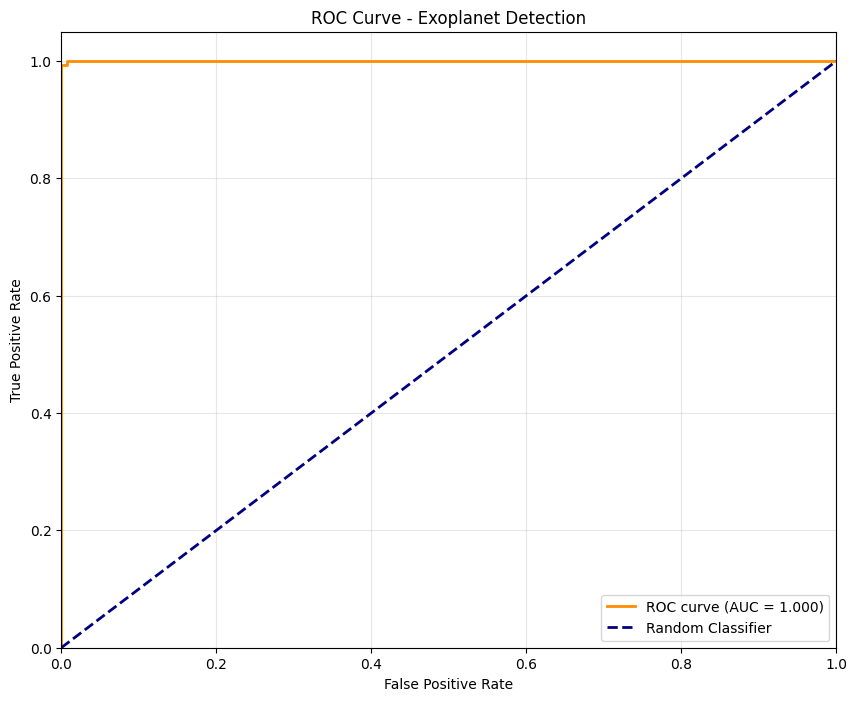

ROC AUC Score: 1.000

Classification Report:
              precision    recall  f1-score   support

   No Planet       1.00      0.95      0.97       147
      Planet       0.95      1.00      0.97       153

    accuracy                           0.97       300
   macro avg       0.98      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300



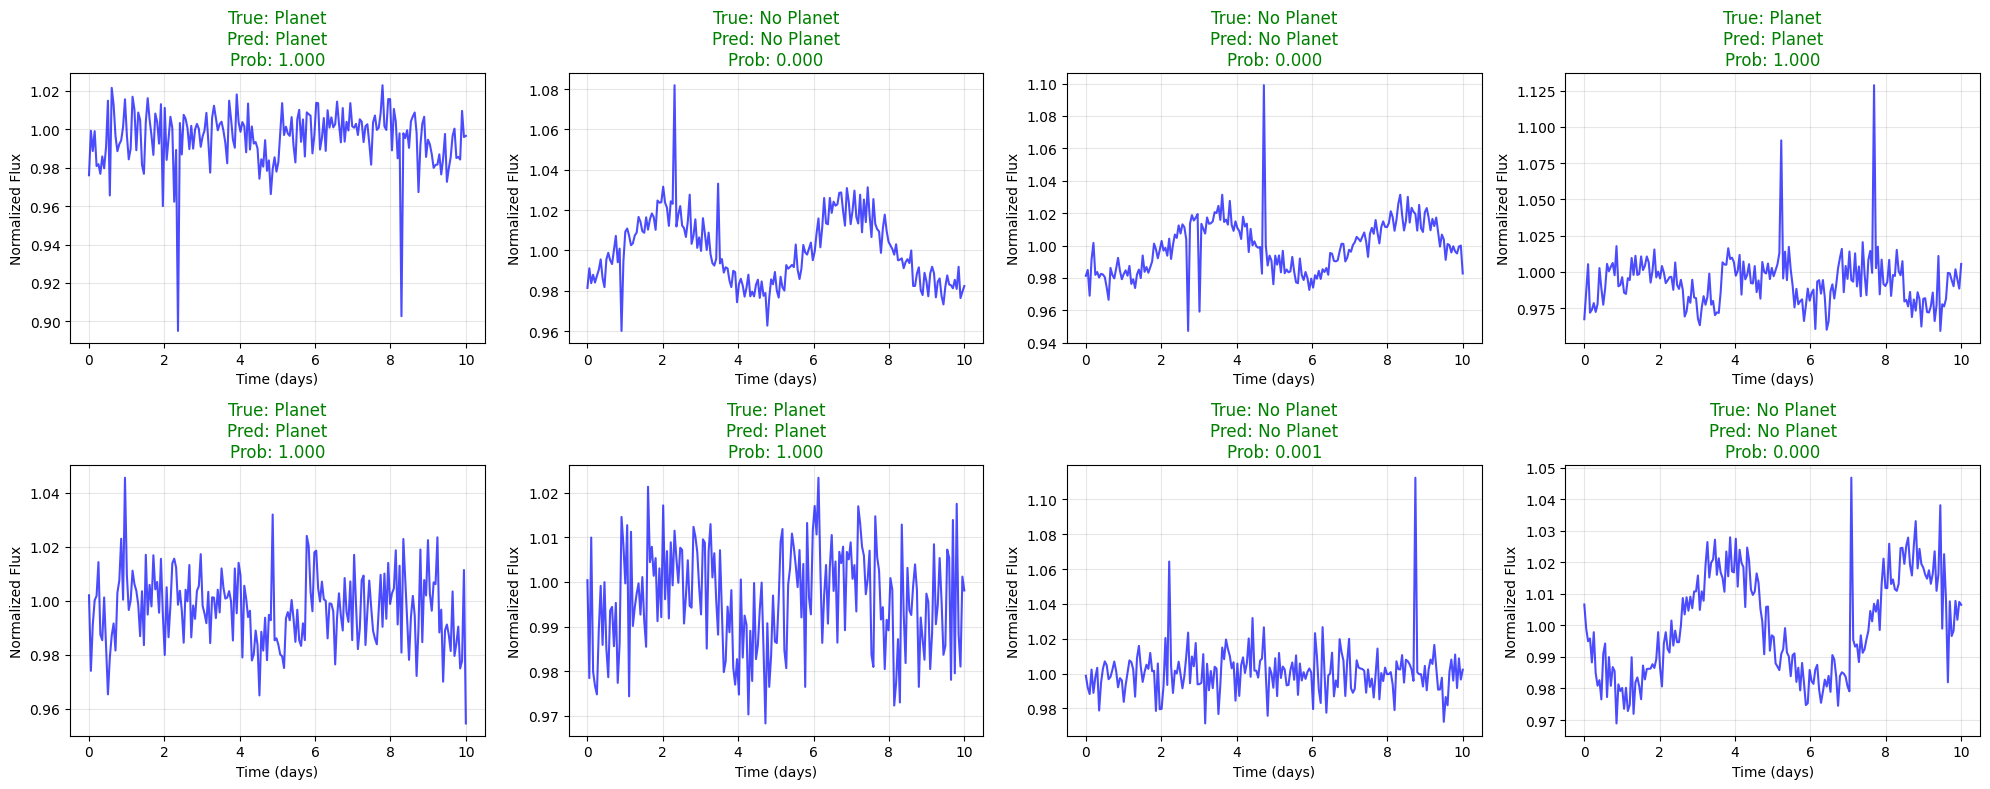

In [13]:
# @title Evaluate Model & Plot ROC Curve
print("VALUATING MODEL PERFORMANCE...")

model.eval()
test_predictions = []
test_targets = []
test_probabilities = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device).squeeze()
        output = model(data)
        probabilities = torch.softmax(output, dim=1)

        test_predictions.extend(output.argmax(dim=1).cpu().numpy())
        test_targets.extend(target.cpu().numpy())
        test_probabilities.extend(probabilities[:, 1].cpu().numpy())  # Probability of class 1 (planet)

test_predictions = np.array(test_predictions)
test_targets = np.array(test_targets)
test_probabilities = np.array(test_probabilities)

# Calculating ROC curve and AUC
fpr, tpr, thresholds = roc_curve(test_targets, test_probabilities)
roc_auc = auc(fpr, tpr)

# Plotting ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Exoplanet Detection')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

print(f"ROC AUC Score: {roc_auc:.3f}")
print("\nClassification Report:")
print(classification_report(test_targets, test_predictions, target_names=['No Planet', 'Planet']))

# Plotting some test examples with predictions
fig, axes = plt.subplots(2, 4, figsize=(20, 8))
time = np.linspace(0, 10, 200)

for i in range(8):
    row, col = i // 4, i % 4
    idx = i * 10  # Sample different test examples

    axes[row, col].plot(time, test_dataset[idx][0].squeeze().numpy(), 'b-', alpha=0.7)

    true_label = test_dataset[idx][1].item()
    pred_label = test_predictions[idx]
    prob = test_probabilities[idx]

    color = 'green' if true_label == pred_label else 'red'
    axes[row, col].set_title(f"True: {'Planet' if true_label == 1 else 'No Planet'}\n"
                           f"Pred: {'Planet' if pred_label == 1 else 'No Planet'}\n"
                           f"Prob: {prob:.3f}", color=color)
    axes[row, col].set_ylabel('Normalized Flux')
    axes[row, col].set_xlabel('Time (days)')
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [14]:
# @title Save Model & Results
print("SAVING RESULTS...")

# Save the trained model
torch.save({
    'model_state_dict': model.state_dict(),
    'roc_auc': roc_auc,
    'test_accuracy': 100 * (test_predictions == test_targets).mean()
}, 'exoplanet_classifier.pth')

print("Model saved as 'exoplanet_classifier.pth'")

# Save results to CSV
results_df = pd.DataFrame({
    'true_labels': test_targets,
    'predicted_labels': test_predictions,
    'planet_probability': test_probabilities
})
results_df.to_csv('light_curve_classification_results.csv', index=False)

print("Results saved to 'light_curve_classification_results.csv'")

print("\n  COMPLETED SUCCESSFULLY!")
print("Files to download:")
print("   • exoplanet_classifier.pth")
print("   • light_curve_classification_results.csv")

# Download files
from google.colab import files
files.download('exoplanet_classifier.pth')
files.download('light_curve_classification_results.csv')

SAVING RESULTS...
Model saved as 'exoplanet_classifier.pth'
Results saved to 'light_curve_classification_results.csv'

  COMPLETED SUCCESSFULLY!
Files to download:
   • exoplanet_classifier.pth
   • light_curve_classification_results.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>